In [40]:
from utils import *
from plotting import *
import json

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw

np.random.seed(33)

In [13]:
RUNDIR = "/home/mila/s/stephen.lu/scratch/gfn_gene/wandb_sweeps"
CONFIG_NAME = "all_gfn.json"

In [38]:
def load_run(run, k=3):
    target_idx, run_paths, rew_thresh = run["target_idx"], run["run_paths"], run["reward_thresh"]
    target_sample_path = f"/home/mila/s/stephen.lu/gfn_gene/res/mmc/targets/sample_{target_idx}.pkl"

    # Load target fingerprint, smiles, latents, active assay cols (if any)
    target_smi, target_fp, _,_,_,_ =\
        load_target_from_path(target_sample_path, None, target_mode=None)
   
    # print(f"Target struct~{TARGET_MODE} alignment: ", target_reward)
    print(f"Processing samples for {target_idx}")
    print(f"Target smi: ", target_smi)

    run_id = run_paths["Morph"]
    run_path = os.path.join(RUNDIR, run_id)
    full_fps, full_rewards, full_smis = load_datum_from_run(
        RUNDIR, run_id, remove_duplicates=True,
        fps_from_file=False, save_fps=False, last_k=1000
    )

    # Create run_datum object with duplicates
    run_datum = { "smis": full_smis, "rewards": full_rewards, "fps": full_fps }

    # Remove duplicates
    run_datum = remove_duplicates_from_run(run_datum)
    rewards, smis, fps = run_datum["rewards"], run_datum["smis"], run_datum["fps"]
        
    # Compute top-k modes by reward and by sim
    top_k_reward_idx = np.argsort(rewards)[::-1][:k]
    top_k_modes_idx, _ = find_modes_from_arrays(rewards, smis, fps, k=k, sim_threshold=0.3, return_fps=True)

    # Keep k best samples with high reward
    best_idxs = np.argsort(full_rewards)[-k:]
    best_rewards = [full_rewards[i] for i in best_idxs]
    best_smis = [full_smis[i] for i in best_idxs]

    # Keep k best samples by modes
    best_modes_idxs = top_k_modes_idx
    best_modes_rewards = [rewards[i] for i in best_modes_idxs]
    best_modes_smis = [smis[i] for i in best_modes_idxs]

    # return target_smi, best_smis, best_rewards
    return target_smi, best_modes_smis, best_modes_rewards

Processing samples for 8505
Target smi:  CC(=O)Nc1ccc(C(=O)Nc2ccccc2N)cc1


0it [00:00, ?it/s]

640000it [00:01, 595583.01it/s]


Removed 31225 duplicates
Generating fps...


100%|██████████| 1000/1000 [00:00<00:00, 4248.00it/s]


Removed 0 duplicates


 38%|███▊      | 377/1000 [00:00<00:00, 270855.19it/s]


Processing samples for 338
Target smi:  O=C(Nc1ccc(N2CCCC2)cc1)c1ccc2ccccc2c1


640000it [00:01, 628227.50it/s]


Removed 491699 duplicates
Generating fps...


100%|██████████| 1000/1000 [00:00<00:00, 5576.85it/s]


Removed 0 duplicates


 16%|█▌        | 159/1000 [00:00<00:00, 258486.18it/s]


Processing samples for 10075
Target smi:  Cc1cccc(C=Cc2ccccc2)n1


640000it [00:01, 627570.84it/s]


Removed 575117 duplicates
Generating fps...


100%|██████████| 1000/1000 [00:00<00:00, 5486.25it/s]


Removed 0 duplicates


  8%|▊         | 84/1000 [00:00<00:00, 204126.03it/s]


Processing samples for 8206
Target smi:  COc1ccc(NC(=O)c2cccc(NC(=O)C(C)C)c2)c([N+](=O)[O-])c1


640000it [00:01, 525737.78it/s]


Removed 587 duplicates
Generating fps...


100%|██████████| 1000/1000 [00:00<00:00, 3638.69it/s]


Removed 0 duplicates


  1%|          | 9/1000 [00:00<00:00, 46660.98it/s]


Processing samples for 9277
Target smi:  O=C(CNc1ccccc1-c1ccccc1)NCc1ccccc1


640000it [00:01, 612634.29it/s]


Removed 3392 duplicates
Generating fps...


100%|██████████| 1000/1000 [00:00<00:00, 5027.15it/s]


Removed 0 duplicates


  2%|▏         | 15/1000 [00:00<00:00, 67288.30it/s]


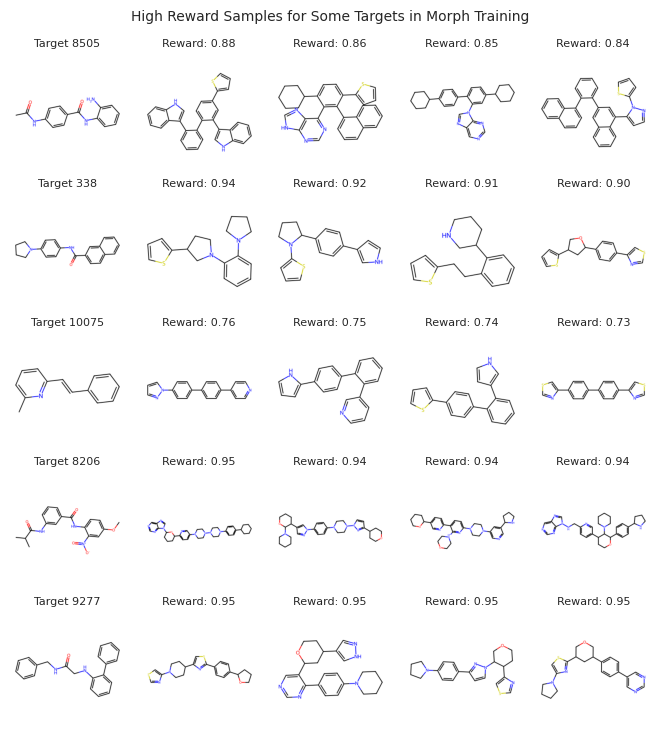

In [41]:
# Load runs from JSON config
with open(f"json/{CONFIG_NAME}") as f:
    RUNS = json.load(f)

# randomly select some targets
TARGETS = [run['target_idx'] for run in RUNS]
TARGETS = np.random.choice(TARGETS, 5, replace=False)

j = 0
k = 4
fig, ax = plt.subplots(len(TARGETS), k+1, figsize=(6.75, 1.5*len(TARGETS)))

for run in RUNS:
    target_idx = run['target_idx']
    if target_idx not in TARGETS: continue
    target_smi, best_smis, best_rewards = load_run(run, k)

    # Plot target
    ax[j, 0].set_title(f"Target {target_idx}", fontsize=8)
    mol = Chem.MolFromSmiles(target_smi)
    img = Draw.MolToImage(mol)
    ax[j, 0].imshow(img)
    ax[j, 0].axis('off')

    # Plot best samples
    for i, (smi, reward) in enumerate(zip(best_smis, best_rewards)):
        mol = Chem.MolFromSmiles(smi)
        img = Draw.MolToImage(mol)
        ax[j, i+1].set_title(f"Reward: {reward:.2f}", fontsize=8)
        ax[j, i+1].imshow(img)
        ax[j, i+1].axis('off')

    j += 1

# add global title
fig.suptitle("High Reward Samples for Some Targets in Morph Training", fontsize=10)
plt.tight_layout()
plt.savefig(f"samples.pdf", bbox_inches='tight', dpi=300)